In [2]:
%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#import deepLIFT stuff
scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR to point to the deeplift code (WITHIN the deeplift repo)");
sys.path.insert(0,scriptsDir);
#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

import keras_conversion as kc

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [3]:
model_weights = "record_9_model_guiTJ_modelWeights.h5"
model_yaml = "record_9_model_guiTJ_modelYaml.yaml"
reload(kc)
keras_model = kc.load_keras_model(model_weights, model_yaml, normalise_conv_for_one_hot_encoded_input=True)

Using Theano backend.


In [4]:
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to the deeplift code");
sys.path.insert(0,scriptsDir);
from importDataPackage import importData
reload(importData)
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml","yaml/labels.yaml", "yaml/splits.yaml")

(0, 'rows skipped from', 'singleMotifSim_motif-CTCF_known1_seqLength-150_numSeqs-1000.simdata.gz')
(0, 'rows skipped from', 'singleMotifSim_seqLength-150_numSeqs-1000.simdata.gz')
Returning desired dict
Making numpy arrays out of the loaded files
('train', 'shape', (1400, 1, 4, 150))
('train', 'shape', (1400, 2))
('test', 'shape', (300, 1, 4, 150))
('test', 'shape', (300, 2))
('valid', 'shape', (300, 1, 4, 150))
('valid', 'shape', (300, 2))


In [5]:
data = testData

In [34]:
import blobs
reload(blobs)
from blobs import MxtsMode
reload(kc)
import models
reload(models)
deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT)
deeplift_contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=0)
deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(find_scores_layer_idx=0)

In [35]:
gradients_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.Gradient)
grad_times_inp_func = gradients_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackprop)
guided_backprop_func = guided_backprop_model.get_target_contribs_func(find_scores_layer_idx=0)
deconv_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeconvNet)
deconv_func = deconv_model.get_target_contribs_func(find_scores_layer_idx=0)
guided_backprop_deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT)
guided_backprop_deeplift_func = guided_backprop_deeplift_model.get_target_contribs_func(find_scores_layer_idx=0)

In [36]:
deeplift_contribs,\
deeplift_multipliers,\
grad_times_inp,\
guided_backprop,\
guided_backprop_deeplift,\
deconv = [np.array(contribs_func(task_idx=0, input_data_list=[data.X] , batch_size=10, progress_update=None))
                  for contribs_func in [deeplift_contribs_func,
                                        deeplift_multipliers_func,
                                        grad_times_inp_func,
                                        guided_backprop_func,
                                        guided_backprop_deeplift_func,
                                        deconv_func]]

In [37]:
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to the enhancer_prediction_code repo");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT");
from deepLIFTutils import makePngOfSequenceDeepLIFTScores, plotWeights

grad_times_inp


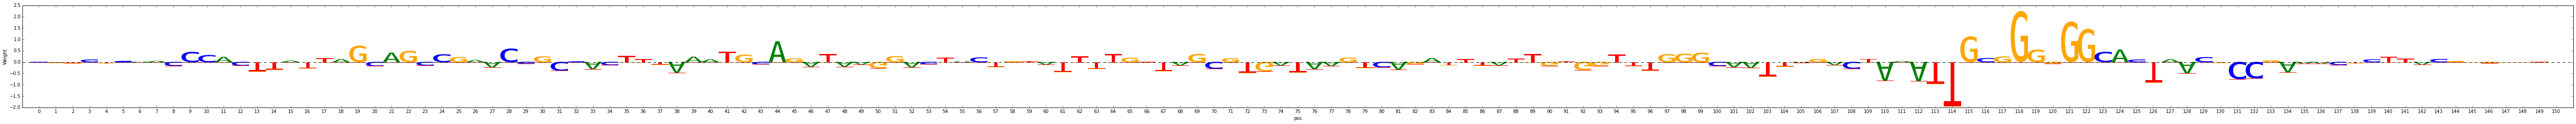

In [ ]:
for (scores, scores_name) in [
            (grad_times_inp, 'grad_times_inp'),
            (guided_backprop, 'guided_backprop'),
            (deeplift_contribs, 'deeplift_contribs'),
            (deeplift_multipliers, 'deeplift_multipliers'),                                  
            (guided_backprop_deeplift, 'guided_backprop_deeplift')]:
    print(scores_name)
    plotWeights(scores[0][0].T, bias=0, title="", figSize=(100,4), outputFile=None)

In [24]:
deeplift_contribs.shape

(300, 1, 4, 150)

In [26]:
np.max(deeplift_multipliers*data.X)

3.7357213497161865